# Imports

In [1]:
!pip3 install -q git+https://github.com/vasudevgupta7/gsoc-wav2vec2@main
#!sudo apt-get install -y libsndfile1-dev
!pip3 install -q SoundFile
%matplotlib inline 

In [2]:
import os

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.metrics import Recall, Accuracy
from tensorflow.keras.activations import tanh
from wav2vec2 import Wav2Vec2Config

from tensorflow.python.keras.callbacks import EarlyStopping

import numpy as np

import soundfile as sf

from IPython.display import Audio, display
import random

from wav2vec2 import Wav2Vec2Processor

import matplotlib.pyplot as plt

print("TF version:", tf.__version__)

TF version: 2.8.0


# Hyper Params

In [3]:
classes = ['fru', 'ang', 'sad', 'hap']

model_folder = "models"

experiment_name = "wav2vec2_trainable"

AUDIO_MAXLEN = 246000 # to mimic the artical original is 246000
LABEL_MAXLEN = 4
BATCH_SIZE =  8


LEARNING_RATE = 1e-6 

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
loss_func = "categorical_crossentropy"
patience = 4
callbacks = [EarlyStopping(monitor="val_accuracy", patience=patience, restore_best_weights=True)]
historys = []


# Model

In [4]:

def get_wav2vec_model():
    pretrained_layer = hub.KerasLayer("https://tfhub.dev/vasudevgupta7/wav2vec2/1", trainable=True)

    inputs = tf.keras.Input(shape=(AUDIO_MAXLEN,))
    hidden_states = pretrained_layer(inputs)
    hidden_drop = tf.keras.layers.Dropout(0.2)(hidden_states)
    fc1 = tf.keras.layers.Dense(512,activation = "relu")(hidden_drop)
    fc1_drop = tf.keras.layers.Dropout(0.2)(fc1)
    fc2 = tf.keras.layers.Dense(252,activation = "relu")(fc1_drop)
    avg = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_last")(fc2)
    outputs = tf.keras.layers.Dense(len(classes), activation="softmax")(avg)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model(tf.random.uniform(shape=(1, AUDIO_MAXLEN)))
    model.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    model.summary()
    return model

# Data Functions

In [5]:
data_dir = "../Data/Audio/"
sessions_dir = [data_dir + "/Ses01", data_dir + "/Ses02", data_dir + "/Ses03", data_dir + "/Ses04", data_dir + "/Ses05"]


In [6]:
REQUIRED_SAMPLE_RATE = 16000

def read_wav_file(file_path):
  with open(file_path, "rb") as f:
      audio, sample_rate = sf.read(f)
  if sample_rate != REQUIRED_SAMPLE_RATE:
      raise ValueError(
          f"sample rate (={sample_rate}) of your files must be {REQUIRED_SAMPLE_RATE}"
      )
  file_id = os.path.split(file_path)[-1][:-len(".wav")]
  return {file_id: audio}

In [7]:
all_files = os.listdir(sessions_dir[0])

wav_files = [f for f in all_files if f.endswith(".wav")]

print("Total sound files:", len(wav_files))
file_id = random.choice([f[:-len(".wav")] for f in wav_files])
wav_file_path = os.path.join(sessions_dir[0], f"{file_id}.wav")
print(f"\nAudio from {wav_file_path}:")
display(Audio(filename=wav_file_path, autoplay=True, rate=16000))

Total sound files: 981

Audio from ../Data/Audio//Ses01/Ses01M_impro06_M013-sad.wav:


In [8]:
def get_label(wav_file):
    label = wav_file.split("-")[-1].split(".")[0]
    if label == "exc":
        label = "hap"
    return label

def get_label_vec(label):
    label_vec = np.zeros(len(classes))
    label_vec[classes.index(label)] = 1
    return label_vec

def calc_data_len(dataset, batch_size = 1):
    count = 0
    for batch in dataset:
        count += 1
    return count * batch_size

def calc_distribution(labels, classes, data_name = ""):
    counter = {}
    for i in range(len(classes)):
        counter[i] = 0
    for x,label in labels:
        idx = np.argmax(label, axis=-1)
        counter[idx] += 1
    res = f"{data_name} Data Has {len(labels)} Samples: "
    for classIdx in counter:
        res += f"Class {classes[classIdx]} has {counter[classIdx]} samples"
        if classIdx == len(classes) - 1:
            res += "."
        else:
            res += ", "
    print(res + "\n")
    return counter

In [9]:
processor = Wav2Vec2Processor(is_tokenizer=False)

def preprocess_speech(audio):
  audio = tf.constant(audio, dtype=tf.float32)
  return processor(tf.transpose(audio))

In [10]:
def fetch_sound_label_list(data_dir):
  all_files = os.listdir(data_dir)

  wav_files = [os.path.join(data_dir, f) for f in all_files if f.endswith(".wav")]
  
  speech_samples = {}
  for f in wav_files:
    speech_samples.update(read_wav_file(f))


  samples = [(speech_samples[file_id], get_label_vec(get_label(file_id))) for file_id in speech_samples.keys() if len(speech_samples[file_id]) < AUDIO_MAXLEN]
  return samples

In [11]:
def get_dataset(data_dir):
    samples = fetch_sound_label_list(data_dir)
    
    def inputs_generator():
        for speech, label in samples:
            yield preprocess_speech(speech), label

    output_signature = (
        tf.TensorSpec(shape=(None),  dtype=tf.float32),
        tf.TensorSpec(shape=(len(classes),), dtype=tf.float32)
        )

    dataset = tf.data.Dataset.from_generator(inputs_generator, output_signature=output_signature)
    BUFFER_SIZE = len(samples)
    SEED = 42
    counter = calc_distribution(samples, classes, data_name=data_dir.split("/")[-1])
    return dataset , counter


def get_k_fold(sessions, ses_idx = 0, batch_data = True):
    if ses_idx == None:
        ses_idx = -1
    else:
        ses_idx = ses_idx % len(sessions)
    tmp_ses_idx = (ses_idx + 1)% len(sessions)
    train_set = sessions[tmp_ses_idx]

    for i in range(len(sessions)):
        if i == tmp_ses_idx:
            continue
        elif i == ses_idx:
            val_set = sessions[i]
        else:
            train_set = train_set.concatenate(sessions[i])

    train_len = calc_data_len(train_set)
    if not ses_idx == -1:
        val_len = calc_data_len(val_set)
    else:
        val_len = 0
    if batch_data:
        train_set = train_set.padded_batch(BATCH_SIZE, padded_shapes=(AUDIO_MAXLEN, LABEL_MAXLEN), padding_values=(0.0, 0.0)).prefetch(tf.data.AUTOTUNE).shuffle(train_len,reshuffle_each_iteration = True)
        if not ses_idx == -1:
            val_set = val_set.padded_batch(BATCH_SIZE, padded_shapes=(AUDIO_MAXLEN, LABEL_MAXLEN), padding_values=(0.0, 0.0)).prefetch(tf.data.AUTOTUNE)

    print(f"Train set length is:{train_len}, Validation set length is:{val_len}")
    if ses_idx == -1:
        return train_set
    return train_set, val_set

In [12]:
def get_class_weight(distributions, fold):
    weights = dict()
    dist = [0 for i in range(len(classes))]
    sum = 0
    for i in range(len(distributions)):
        if i == fold:
            continue
        for class_idx in distributions[i]:
            dist[class_idx] += distributions[i][class_idx]
            sum += distributions[i][class_idx]

    for i in range(len(distributions)):
        if i == fold:
            continue
        for class_idx in distributions[i]:
            weights[class_idx] = sum/ (len(classes)* dist[class_idx])

    return weights

# Evaluation Functions

In [13]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  train_loss = round(history.history['loss'][-patience- 1], 2)
  valid_loss = round(history.history['val_loss'][-patience- 1], 2)
  print(f'The model loss on train data is: {train_loss}')
  print(f'The model loss on validation data is: {valid_loss}')

def plot_accuracy(history,patience):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  train_accuracy = round(history.history['accuracy'][-patience - 1], 2)
  valid_accuracy = round(history.history['val_accuracy'][-patience- 1], 2)
  print(f'The model accuracy on train data is: {train_accuracy}')
  print(f'The model accuracy on validation data is: {valid_accuracy}')

def plot_history(history,patience):
  plot_loss(history)
  plot_accuracy(history,patience)

In [14]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, recall_score
classes = ["fru","ang","sad","hap"]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def evaluate_model(model, dataset):
    y_pred = []
    y_true = []
    correct = 0
    count = 0
    for x,y in dataset:
        pred = model.predict(x=x, verbose=0)
        y = y.numpy()
        pred = np.argmax(pred, axis=-1)
        y = np.argmax(y, axis=-1)
        assert len(pred) == len(y)
        batch_len = len(pred)
        for i in range(batch_len):
            if y[i] == pred[i]:
                correct += 1
            y_pred.append(pred[i])
            y_true.append(y[i])
        count += batch_len
        


    acc = float(correct / count)
    acc = format(acc, ".3f")
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    #recall = recall_score(y_true=y_true, y_pred=y_pred, labels=[0,1,2,3], average='micro')
    #recall = format(recall, ".3f")
    plot_confusion_matrix(cm=cm, classes=classes, title=f"Confusion Matrix {acc}% Accuracy")
    

# Loading Data

In [15]:
tf.random.set_seed(42)
sessions = []
sessions_distibution = []
for ses_dir in sessions_dir:
    ds , dist = get_dataset(ses_dir)
    sessions.append(ds)
    sessions_distibution.append(dist)

Ses01 Data Has 965 Samples: Class fru has 280 samples, Class ang has 225 samples, Class sad has 186 samples, Class hap has 274 samples.

Ses02 Data Has 975 Samples: Class fru has 322 samples, Class ang has 137 samples, Class sad has 190 samples, Class hap has 326 samples.

Ses03 Data Has 1209 Samples: Class fru has 382 samples, Class ang has 239 samples, Class sad has 304 samples, Class hap has 284 samples.

Ses04 Data Has 1244 Samples: Class fru has 479 samples, Class ang has 325 samples, Class sad has 139 samples, Class hap has 301 samples.

Ses05 Data Has 1214 Samples: Class fru has 374 samples, Class ang has 168 samples, Class sad has 238 samples, Class hap has 434 samples.



# Experiment 1

In [16]:
ses_idx = 0
train_set, val_set = get_k_fold(sessions, ses_idx)
class_weights = get_class_weight(sessions_distibution,ses_idx)
print(class_weights)

Train set length is:4642, Validation set length is:965
{0: 0.7453436095054592, 1: 1.3354430379746836, 2: 1.3323765786452353, 3: 0.8628252788104089}


In [17]:
model_name = f"{experiment_name}_artical_fold{ses_idx + 1}"
model = get_wav2vec_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 246000)]          0         
                                                                 
 keras_layer (KerasLayer)    (None, 768, 768)          94371712  
                                                                 
 dropout (Dropout)           (None, 768, 768)          0         
                                                                 
 dense (Dense)               (None, 768, 512)          393728    
                                                                 
 dropout_1 (Dropout)         (None, 768, 512)          0         
                                                                 
 dense_1 (Dense)             (None, 768, 252)          129276    
                                                                 
 global_average_pooling1d (G  (None, 252)              0     

In [18]:
history = model.fit(train_set ,validation_data=val_set, epochs=100,callbacks = callbacks,class_weight = class_weights, verbose=1, shuffle=True)
model.save(f"{model_folder}/{model_name}")
historys.append(history)

Epoch 1/100


581/581 [==============================] - 346s 568ms/step - loss: 1.2689 - accuracy: 0.3578 - val_loss: 1.1939 - val_accuracy: 0.4321
Epoch 2/100
581/581 [==============================] - 334s 566ms/step - loss: 1.1032 - accuracy: 0.4457 - val_loss: 1.2081 - val_accuracy: 0.4383
Epoch 3/100
581/581 [==============================] - 334s 566ms/step - loss: 1.0295 - accuracy: 0.4976 - val_loss: 1.1331 - val_accuracy: 0.5326
Epoch 4/100
581/581 [==============================] - 334s 566ms/step - loss: 0.9672 - accuracy: 0.5373 - val_loss: 1.0327 - val_accuracy: 0.5699
Epoch 5/100
581/581 [==============================] - 334s 566ms/step - loss: 0.8999 - accuracy: 0.5799 - val_loss: 1.1590 - val_accuracy: 0.5409
Epoch 6/100
581/581 [==============================] - 334s 566ms/step - loss: 0.8557 - accuracy: 0.6066 - val_loss: 1.0333 - val_accuracy: 0.5731
Epoch 7/100
581/581 [==============================] - 334s 566ms/step - loss: 0.7946 - accuracy: 0.6424 - val_loss: 1.0257 - val_

INFO:tensorflow:Assets written to: models/wav2vec2_trainable_artical_fold1/assets


INFO:tensorflow:Assets written to: models/wav2vec2_trainable_artical_fold1/assets


Confusion matrix, without normalization
[[102  60  64  54]
 [ 44 138  15  28]
 [  9   1 175   1]
 [ 26  12  51 185]]


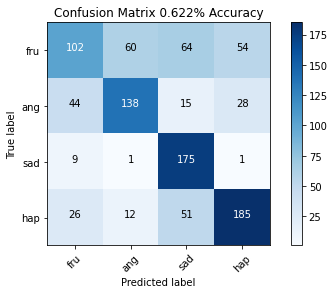

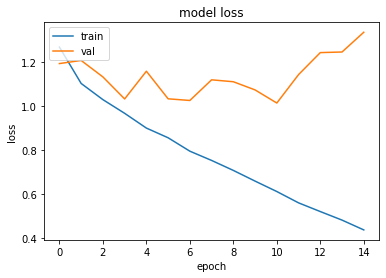

The model loss on train data is: 0.61
The model loss on validation data is: 1.01


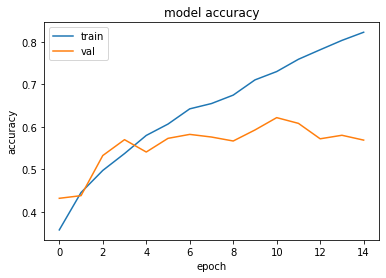

The model accuracy on train data is: 0.73
The model accuracy on validation data is: 0.62


In [19]:
evaluate_model(model, val_set)
plot_history(history,patience)

# Experiment 2

In [20]:
ses_idx = 1
train_set, val_set = get_k_fold(sessions, ses_idx)
class_weights = get_class_weight(sessions_distibution,ses_idx)
print(class_weights)

Train set length is:4632, Validation set length is:975
{0: 0.7643564356435644, 1: 1.2100313479623825, 2: 1.3356401384083045, 3: 0.8955916473317865}


In [21]:
model_name = f"{experiment_name}_artical_fold{ses_idx + 1}"
model = get_wav2vec_model()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 246000)]          0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 768, 768)          94371712  
                                                                 
 dropout_2 (Dropout)         (None, 768, 768)          0         
                                                                 
 dense_3 (Dense)             (None, 768, 512)          393728    
                                                                 
 dropout_3 (Dropout)         (None, 768, 512)          0         
                                                                 
 dense_4 (Dense)             (None, 768, 252)          129276    
                                                                 
 global_average_pooling1d_1   (None, 252)              0   

In [22]:
history = model.fit(train_set ,validation_data=val_set, epochs=100,callbacks = callbacks,class_weight = class_weights, verbose=1, shuffle=True)
model.save(f"{model_folder}/{model_name}")
historys.append(history)

Epoch 1/100


579/579 [==============================] - 344s 570ms/step - loss: 1.1905 - accuracy: 0.3819 - val_loss: 1.1302 - val_accuracy: 0.4195
Epoch 2/100
579/579 [==============================] - 334s 567ms/step - loss: 1.0468 - accuracy: 0.4745 - val_loss: 1.0370 - val_accuracy: 0.5190
Epoch 3/100
579/579 [==============================] - 334s 567ms/step - loss: 0.9736 - accuracy: 0.5354 - val_loss: 0.9957 - val_accuracy: 0.5456
Epoch 4/100
579/579 [==============================] - 333s 567ms/step - loss: 0.9024 - accuracy: 0.5823 - val_loss: 1.0422 - val_accuracy: 0.5026
Epoch 5/100
579/579 [==============================] - 333s 567ms/step - loss: 0.8622 - accuracy: 0.6028 - val_loss: 0.9974 - val_accuracy: 0.5426
Epoch 6/100
579/579 [==============================] - 333s 566ms/step - loss: 0.8195 - accuracy: 0.6297 - val_loss: 1.1129 - val_accuracy: 0.5333
Epoch 7/100
579/579 [==============================] - 333s 567ms/step - loss: 0.7805 - accuracy: 0.6490 - val_loss: 1.0593 - val_

INFO:tensorflow:Assets written to: models/wav2vec2_trainable_artical_fold2/assets


INFO:tensorflow:Assets written to: models/wav2vec2_trainable_artical_fold2/assets


Confusion matrix, without normalization
[[170  48  26  78]
 [ 37  85   1  14]
 [ 28   0 134  28]
 [ 70  27  20 209]]


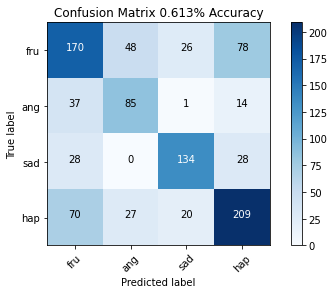

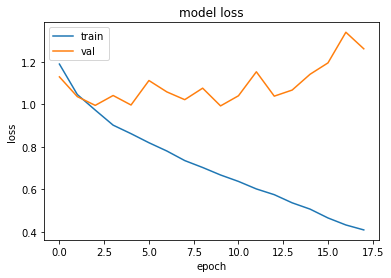

The model loss on train data is: 0.54
The model loss on validation data is: 1.07


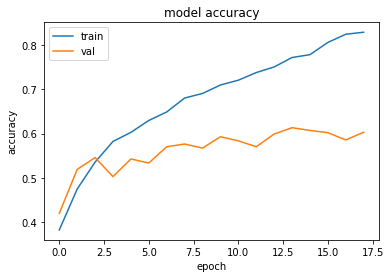

The model accuracy on train data is: 0.77
The model accuracy on validation data is: 0.61


In [23]:
evaluate_model(model, val_set)
plot_history(history,patience)

# Experiment 3

In [24]:
ses_idx = 2
train_set, val_set = get_k_fold(sessions, ses_idx)
class_weights = get_class_weight(sessions_distibution,ses_idx)
print(class_weights)

Train set length is:4398, Validation set length is:1209
{0: 0.7556701030927835, 1: 1.2859649122807018, 2: 1.4601593625498008, 3: 0.8235955056179776}


In [25]:
model_name = f"{experiment_name}_artical_fold{ses_idx + 1}"
model = get_wav2vec_model()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 246000)]          0         
                                                                 
 keras_layer_2 (KerasLayer)  (None, 768, 768)          94371712  
                                                                 
 dropout_4 (Dropout)         (None, 768, 768)          0         
                                                                 
 dense_6 (Dense)             (None, 768, 512)          393728    
                                                                 
 dropout_5 (Dropout)         (None, 768, 512)          0         
                                                                 
 dense_7 (Dense)             (None, 768, 252)          129276    
                                                                 
 global_average_pooling1d_2   (None, 252)              0   

In [26]:
history = model.fit(train_set ,validation_data=val_set, epochs=100,callbacks = callbacks,class_weight = class_weights, verbose=1, shuffle=True)
model.save(f"{model_folder}/{model_name}")
historys.append(history)

Epoch 1/100


550/550 [==============================] - 333s 582ms/step - loss: 1.1351 - accuracy: 0.4138 - val_loss: 1.1216 - val_accuracy: 0.4789
Epoch 2/100
550/550 [==============================] - 323s 578ms/step - loss: 0.9879 - accuracy: 0.5152 - val_loss: 1.1150 - val_accuracy: 0.4971
Epoch 3/100
550/550 [==============================] - 323s 578ms/step - loss: 0.9026 - accuracy: 0.5657 - val_loss: 1.1036 - val_accuracy: 0.5277
Epoch 4/100
550/550 [==============================] - 323s 578ms/step - loss: 0.8271 - accuracy: 0.6066 - val_loss: 1.0717 - val_accuracy: 0.5434
Epoch 5/100
550/550 [==============================] - 323s 578ms/step - loss: 0.7618 - accuracy: 0.6435 - val_loss: 1.0774 - val_accuracy: 0.5467
Epoch 6/100
550/550 [==============================] - 323s 578ms/step - loss: 0.6950 - accuracy: 0.6803 - val_loss: 1.1649 - val_accuracy: 0.5302
Epoch 7/100
550/550 [==============================] - 323s 578ms/step - loss: 0.6409 - accuracy: 0.7121 - val_loss: 1.1507 - val_

INFO:tensorflow:Assets written to: models/wav2vec2_trainable_artical_fold3/assets


INFO:tensorflow:Assets written to: models/wav2vec2_trainable_artical_fold3/assets


Confusion matrix, without normalization
[[198  81  43  60]
 [ 88 111   6  34]
 [ 42   4 240  18]
 [ 74  14  78 118]]


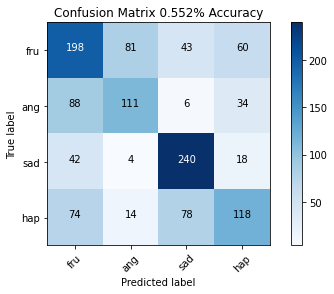

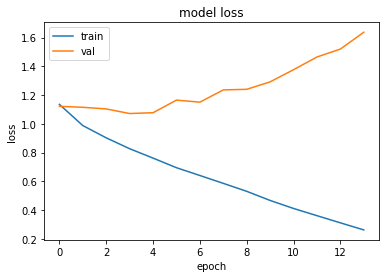

The model loss on train data is: 0.47
The model loss on validation data is: 1.29


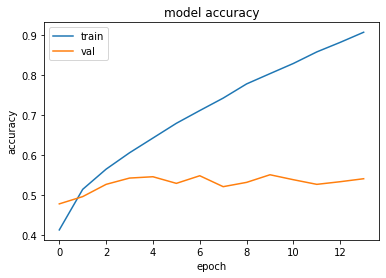

The model accuracy on train data is: 0.8
The model accuracy on validation data is: 0.55


In [27]:
evaluate_model(model, val_set)
plot_history(history,patience)

# Experiment 4

In [28]:
ses_idx = 3
train_set, val_set = get_k_fold(sessions, ses_idx)
class_weights = get_class_weight(sessions_distibution,ses_idx)
print(class_weights)

Train set length is:4363, Validation set length is:1244
{0: 0.8032032400589102, 1: 1.4184005201560468, 2: 1.1881808278867103, 3: 0.8275796661608498}


In [29]:
model_name = f"{experiment_name}_artical_fold{ses_idx + 1}"
model = get_wav2vec_model()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 246000)]          0         
                                                                 
 keras_layer_3 (KerasLayer)  (None, 768, 768)          94371712  
                                                                 
 dropout_6 (Dropout)         (None, 768, 768)          0         
                                                                 
 dense_9 (Dense)             (None, 768, 512)          393728    
                                                                 
 dropout_7 (Dropout)         (None, 768, 512)          0         
                                                                 
 dense_10 (Dense)            (None, 768, 252)          129276    
                                                                 
 global_average_pooling1d_3   (None, 252)              0   

In [30]:
history = model.fit(train_set ,validation_data=val_set, epochs=100,callbacks = callbacks,class_weight = class_weights, verbose=1, shuffle=True)

Epoch 1/100


546/546 [==============================] - 333s 583ms/step - loss: 1.1356 - accuracy: 0.4394 - val_loss: 1.0944 - val_accuracy: 0.4646
Epoch 2/100
546/546 [==============================] - 321s 580ms/step - loss: 0.9709 - accuracy: 0.5537 - val_loss: 1.0645 - val_accuracy: 0.5177
Epoch 3/100
546/546 [==============================] - 322s 580ms/step - loss: 0.8612 - accuracy: 0.6124 - val_loss: 1.0410 - val_accuracy: 0.5289
Epoch 4/100
546/546 [==============================] - 321s 580ms/step - loss: 0.7794 - accuracy: 0.6564 - val_loss: 1.0947 - val_accuracy: 0.5378
Epoch 5/100
546/546 [==============================] - 321s 580ms/step - loss: 0.7035 - accuracy: 0.6972 - val_loss: 1.2176 - val_accuracy: 0.4879
Epoch 6/100
546/546 [==============================] - 322s 580ms/step - loss: 0.6444 - accuracy: 0.7238 - val_loss: 1.0724 - val_accuracy: 0.5458
Epoch 7/100
546/546 [==============================] - 321s 580ms/step - loss: 0.5724 - accuracy: 0.7632 - val_loss: 1.1195 - val_

ResourceExhaustedError: models/wav2vec2_trainable_artical_fold4/variables/variables_temp/part-00000-of-00001.data-00000-of-00001.tempstate9964284205255295838; No space left on device [Op:SaveV2]

In [31]:
model.save(f"{model_folder}/{model_name}")
historys.append(history)

INFO:tensorflow:Assets written to: models/wav2vec2_trainable_artical_fold4/assets


INFO:tensorflow:Assets written to: models/wav2vec2_trainable_artical_fold4/assets


Confusion matrix, without normalization
[[279 129  28  43]
 [ 88 226   0  11]
 [ 37   4  92   6]
 [ 93  64  21 123]]


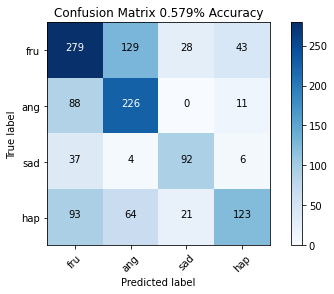

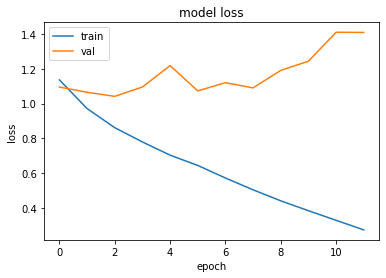

The model loss on train data is: 0.5
The model loss on validation data is: 1.09


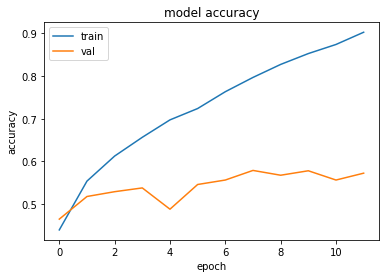

The model accuracy on train data is: 0.8
The model accuracy on validation data is: 0.58


In [32]:
evaluate_model(model, val_set)
plot_history(history,patience)

# Experiment 5

In [33]:
ses_idx = 4
train_set, val_set = get_k_fold(sessions, ses_idx)
class_weights = get_class_weight(sessions_distibution,ses_idx)
print(class_weights)

Train set length is:4393, Validation set length is:1214
{0: 0.7506835269993165, 1: 1.1860151187904968, 2: 1.3409645909645909, 3: 0.9267932489451477}


In [34]:
model_name = f"{experiment_name}_artical_fold{ses_idx + 1}"
model = get_wav2vec_model()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 246000)]          0         
                                                                 
 keras_layer_4 (KerasLayer)  (None, 768, 768)          94371712  
                                                                 
 dropout_8 (Dropout)         (None, 768, 768)          0         
                                                                 
 dense_12 (Dense)            (None, 768, 512)          393728    
                                                                 
 dropout_9 (Dropout)         (None, 768, 512)          0         
                                                                 
 dense_13 (Dense)            (None, 768, 252)          129276    
                                                                 
 global_average_pooling1d_4   (None, 252)              0   

In [35]:
history = model.fit(train_set ,validation_data=val_set, epochs=100,callbacks = callbacks,class_weight = class_weights, verbose=1, shuffle=True)
model.save(f"{model_folder}/{model_name}")
historys.append(history)

Epoch 1/100


550/550 [==============================] - 332s 580ms/step - loss: 1.1497 - accuracy: 0.4348 - val_loss: 1.0889 - val_accuracy: 0.5016
Epoch 2/100
550/550 [==============================] - 323s 578ms/step - loss: 0.9877 - accuracy: 0.5295 - val_loss: 1.1189 - val_accuracy: 0.4802
Epoch 3/100
550/550 [==============================] - 323s 579ms/step - loss: 0.9031 - accuracy: 0.5775 - val_loss: 0.9968 - val_accuracy: 0.5684
Epoch 4/100
550/550 [==============================] - 323s 578ms/step - loss: 0.8181 - accuracy: 0.6235 - val_loss: 0.9619 - val_accuracy: 0.5791
Epoch 5/100
550/550 [==============================] - 323s 578ms/step - loss: 0.7547 - accuracy: 0.6567 - val_loss: 1.0676 - val_accuracy: 0.5643
Epoch 6/100
550/550 [==============================] - 323s 578ms/step - loss: 0.6856 - accuracy: 0.6925 - val_loss: 0.9998 - val_accuracy: 0.5824
Epoch 7/100
550/550 [==============================] - 323s 578ms/step - loss: 0.6208 - accuracy: 0.7259 - val_loss: 1.0700 - val_

INFO:tensorflow:Assets written to: models/wav2vec2_trainable_artical_fold5/assets


INFO:tensorflow:Assets written to: models/wav2vec2_trainable_artical_fold5/assets


Confusion matrix, without normalization
[[209  64  33  68]
 [ 66  78   7  17]
 [ 30   1 165  42]
 [105  16  50 263]]


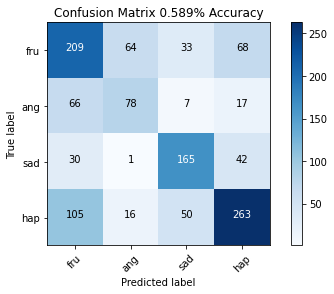

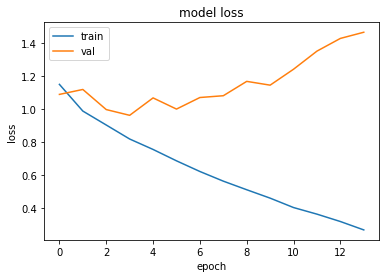

The model loss on train data is: 0.46
The model loss on validation data is: 1.15


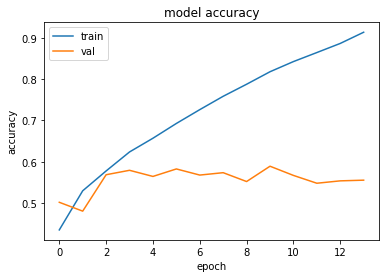

The model accuracy on train data is: 0.82
The model accuracy on validation data is: 0.59


In [36]:
evaluate_model(model, val_set)
plot_history(history,patience)

# Conclusion

------------------------------Experiment 1------------------------------


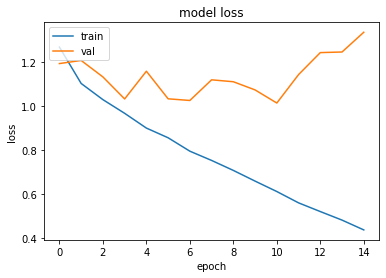

The model loss on train data is: 0.61
The model loss on validation data is: 1.01


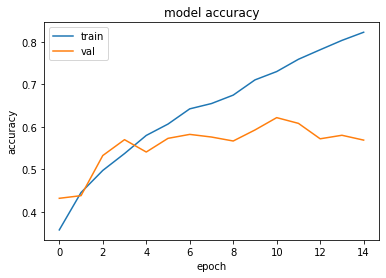

The model accuracy on train data is: 0.73
The model accuracy on validation data is: 0.62
------------------------------Experiment 2------------------------------


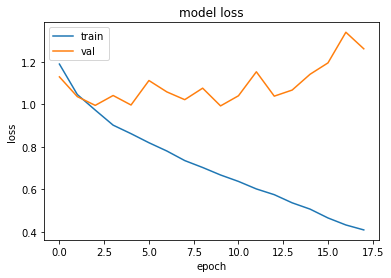

The model loss on train data is: 0.54
The model loss on validation data is: 1.07


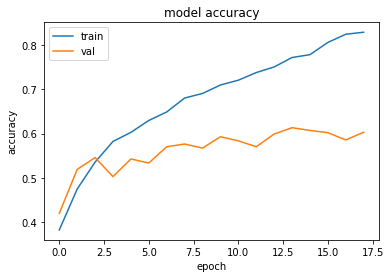

The model accuracy on train data is: 0.77
The model accuracy on validation data is: 0.61
------------------------------Experiment 3------------------------------


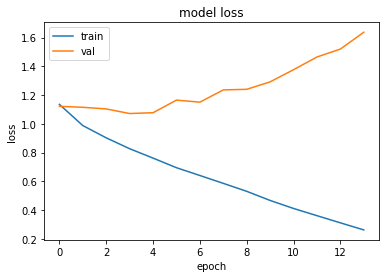

The model loss on train data is: 0.47
The model loss on validation data is: 1.29


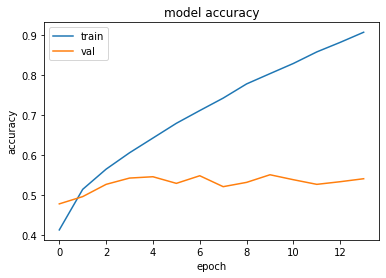

The model accuracy on train data is: 0.8
The model accuracy on validation data is: 0.55
------------------------------Experiment 4------------------------------


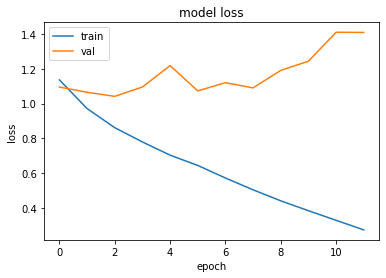

The model loss on train data is: 0.5
The model loss on validation data is: 1.09


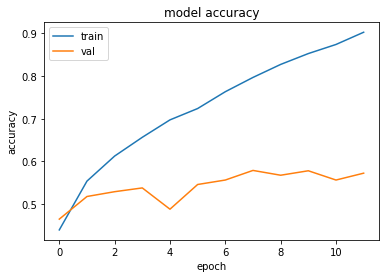

The model accuracy on train data is: 0.8
The model accuracy on validation data is: 0.58
------------------------------Experiment 5------------------------------


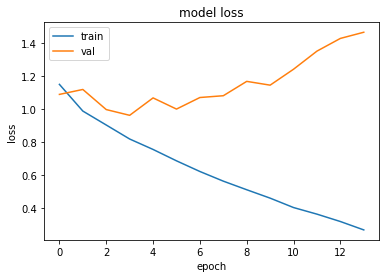

The model loss on train data is: 0.46
The model loss on validation data is: 1.15


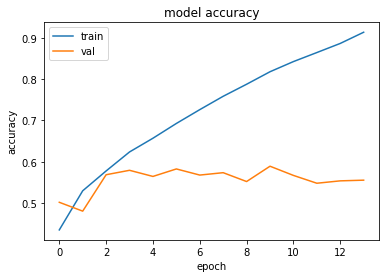

The model accuracy on train data is: 0.82
The model accuracy on validation data is: 0.59


In [37]:
i = 1
for h in historys:
    print(f"------------------------------Experiment {i}------------------------------")
    i += 1
    plot_history(h,patience)